In [1]:
import numpy as np
import matplotlib.pyplot as plt

Now we create different test data for computing the kernel sizes on.

In [2]:

def gaussian_disk():
    """
        Generate a random point in the unit disk using Gaussian sampling.
    """
    point = np.random.normal(loc=0.0, scale=1.0, size=2)
    norm_point = np.linalg.norm(point)
    scaled_point = point / norm_point * np.random.uniform(0, 1)**(1/2)
    return scaled_point


def gaussian_ball():
    """
        Generate a random point in the unit ball using Gaussian sampling.
    """
    point = np.random.normal(loc=0.0, scale=1.0, size=3)
    norm_point = np.linalg.norm(point)
    scaled_point = point / norm_point * np.random.uniform(0, 1)**(1/3)
    return scaled_point

def cutoff_and_rescale_noise(noise, cutoff_radius):
    """
    Cutoff noise vectors that exceed the given radius and rescale them.

    Arguments:
    - noise: (N, d) array of sampled noise vectors.
    - cutoff_radius: The threshold norm for noise.

    Returns:
    - Adjusted noise with norm constraint.
    """
    norms = np.linalg.norm(noise, axis=1)
    mask = norms > cutoff_radius  # Identify outliers

    # Rescale the noise vectors that exceed the cutoff
    noise[mask] = noise[mask] / norms[mask, np.newaxis] * cutoff_radius

    return noise

# Function to generate random points within a 3D ball of radius R
def random_points_in_ball(R, num_points, center = (0, 0, 0), dim=3):
    """
        Generate random points uniformly distributed in a ball of radius R in 'dim' dimensions.
    """
    points = []
    for _ in range(num_points):
        # generate a random point from a 3D Gaussian distribution
        point = gaussian_ball()
        # scale the point to be within the ball
        scaled_point = R*point
        translated_point = scaled_point + np.array(center)
        points.append(scaled_point)
    return np.array(points)

def construct_symmetric_ball(R, num_points, center=(0, 0, 0)):
    """
    Create a ball where every point explicitly includes its negation.
    """
    num_points_half = num_points // 2
    points = random_points_in_ball(R, num_points_half, center=center)
    return np.vstack((points, -points))

def symmetric_ball_shifted(R, num_points, new_center=(3, 3, 3)):
    """
    Generate a symmetric ball centered at the origin and then shift it to a new center.
    
    Parameters:
        R (float): Radius of the ball.
        num_points (int): Total number of points in the ball (including negated points).
        new_center (tuple): The new center to which the ball should be shifted.
    
    Returns:
        ndarray: An array of points representing the shifted symmetric ball.
    """
    # Generate half the points for the symmetric ball
    num_points_half = num_points // 2
    points = []
    
    for _ in range(num_points_half):
        # Generate a random point in the unit ball using Gaussian sampling
        point = np.random.normal(loc=0.0, scale=1.0, size=3)
        norm_point = np.linalg.norm(point)
        scaled_point = point / norm_point * np.random.uniform(0, 1)**(1/3)
        points.append(R * scaled_point)
    
    # Create the symmetric ball by adding negated points
    points = np.array(points)
    symmetric_points = np.vstack((points, -points))
    
    # Shift the ball to the new center
    shifted_points = symmetric_points + np.array(new_center)
    
    return shifted_points

def random_points_in_ball_with_noise(R, num_points, noise_std=0.1, dim=3):
    """
        Generate random points uniformly distributed in a ball of radius R in 'dim' dimensions
        and add Gaussian noise.
    """
    points = random_points_in_ball(R, num_points, dim)
    noise = np.random.normal(0, noise_std, size=points.shape)
    noisy_points = points + noise
    return noisy_points

def random_points_in_ball_with_cutoff_noise(R, num_points, noise_std=0.1, cutoff=0.2, dim=3):
    """
    Generate random points uniformly distributed in a ball of radius R in 'dim' dimensions
    and add Gaussian noise with a cutoff and rescaling.

    Arguments:
    - R: Radius of the ball.
    - num_points: Number of points to generate.
    - noise_std: Standard deviation of the noise.
    - cutoff: Maximum allowable norm for noise.
    - dim: Dimensionality of the space (default 3).

    Returns:
    - Noisy points inside the ball with constrained noise.
    """
    points = random_points_in_ball(R, num_points, dim=dim)
    noise = np.random.normal(0, noise_std, size=points.shape)
    
    # Apply cutoff and rescaling
    noise = cutoff_and_rescale_noise(noise, cutoff)

    noisy_points = points + noise
    return noisy_points


# Function to generate random points in the disk of radius R - 2d or 3d
def random_points_in_disk(R, num_points):
    """
        Generate random points within a 2D disk using Gaussian sampling.

        Arguments:
        - radius: The radius of the disk.
        - num_points: Number of random points to sample.

        Returns:
        - points: Randomly sampled points within the disk.
    """
    points = []

    for _ in range(num_points):
        # generate a random point from a 2D Gaussian distribution
        point = gaussian_disk()
        # scale the point to be within the disk
        scaled_point = R*point
        points.append(scaled_point)
    # Return points as an array of shape (num_points, 2)
    return np.array(points)

def random_points_in_disk_with_noise(R, num_points, noise_std=0.1):
    """
        Generate random points within a 2D disk and add Gaussian noise.
    """
    points = random_points_in_disk(R, num_points)
    noise = np.random.normal(0, noise_std, size=points.shape)
    noisy_points = points + noise
    return noisy_points

def random_points_in_disk_with_cutoff_noise(R, num_points, noise_std=0.1, cutoff=0.2):
    """
    Generate random points uniformly distributed in a disk of radius R in '2D' dimensions
    and add Gaussian noise with a cutoff and rescaling.

    Arguments:
    - R: Radius of the disk.
    - num_points: Number of points to generate.
    - noise_std: Standard deviation of the noise.
    - cutoff: Maximum allowable norm for noise.

    Returns:
    - Noisy points inside the disk with constrained noise.
    """
    points = random_points_in_disk(R, num_points)
    noise = np.random.normal(0, noise_std, size=points.shape)
    
    # Apply cutoff and rescaling
    noise = cutoff_and_rescale_noise(noise, cutoff)

    noisy_points = points + noise
    return noisy_points

def random_points_in_ellipse(a, b, num_points):
    """
        Generate random points within a 2D ellipse using Gaussian sampling.

        Arguments:
        - a: Semi-major axis length.
        - b: Semi-minor axis length.
        - num_points: Number of random points to sample.

        Returns:
        - points: Randomly sampled points within the ellipse.
    """
    points = []
    for _ in range(num_points):
        gaussian_point = gaussian_disk()
        ellipse_point = np.array([a*gaussian_point[0], b*gaussian_point[1]])
        points.append(ellipse_point)
    return np.array(points)

def random_points_in_ellipse_with_noise(a, b, num_points, noise_std=0.1):
    """
        Generate random points within a 2D ellipse and add Gaussian noise.
    """
    points = random_points_in_ellipse(a, b, num_points)
    noise = np.random.normal(0, noise_std, size=points.shape)
    noisy_points = points + noise
    return noisy_points

def random_points_in_ellipsoid(a, b, c, num_points):
    """
        Generate random points within a 3D ellipsoid using Gaussian sampling.

        Arguments:
        - a: Semi-principal axis along the x-axis.
        - b: Semi-principal axis along the y-axis.
        - c: Semi-principal axis along the z-axis.
        - num_points: Number of random points to sample.

        Returns:
        - points: Randomly sampled points within the ellipsoid.
    """
    points = []
    for _ in range(num_points):
        gaussian_point = gaussian_ball()
        ellipsoid_point = np.array([a*gaussian_point[0], b*gaussian_point[1], c*gaussian_point[2]])
        points.append(ellipsoid_point)
    return np.array(points)

def random_points_in_ellipsoid_with_noise(a, b, c, num_points, noise_std=0.1):
    """
        Generate random points within a 3D ellipsoid and add Gaussian noise.
    """
    points = random_points_in_ellipsoid(a, b, c, num_points)
    noise = np.random.normal(0, noise_std, size=points.shape)
    noisy_points = points + noise
    return noisy_points

def random_points_in_ellipsoid_with_cutoff_noise(a, b, c, num_points, noise_std=0.1, cutoff=0.2):
    """
    Generate random points in an ellipsoid and add Gaussian noise with cutoff and rescaling.

    Arguments:
    - a, b, c: Semi-axes of the ellipsoid.
    - num_points: Number of points to generate.
    - noise_std: Standard deviation of the noise.
    - cutoff: Maximum allowable norm for noise.

    Returns:
    - Noisy points inside the ellipsoid with constrained noise.
    """
    points = random_points_in_ellipsoid(a, b, c, num_points)
    noise = np.random.normal(0, noise_std, size=points.shape)
    
    # Apply cutoff and rescaling
    noise = cutoff_and_rescale_noise(noise, cutoff)

    noisy_points = points + noise
    return noisy_points

In [3]:
#subsample k points from array
def subsample_points(input_data, number_samples):
    """ Subsample k points from input data"""

In [4]:
# Function to apply matrix transformation A to points
def apply_forwardmodel(A, points):
    return np.dot(points, A.T)

def projection_nullspace(A, x):
    """
        Compute the projection of a point x onto the null space of A, i.e., P_{\mathcal{N}(A)}(x).
        This is equivalent to (I - A^dagger A) x.
    """
    A_dagger = np.linalg.pinv(A)
    return np.dot(np.eye(A.shape[1]) - np.dot(A_dagger, A), x)

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/var/folders/93/0d4f5dmx4x580p8zm8nf2znr0000gp/T/ipykernel_6810/3471909342.py:6: SyntaxWarning: invalid escape sequence '\m'
  """


In [5]:
# Algorithm 1: Iterative Diameter Estimation
def diameters_feasiblesets_noiseless(A, input_data, target_data, p, epsilon=1e-2):
    """
        Implements the iterative algorithm for diameter estimation of the feasible set, consisting of all possible target data points, for each target point.
        Arguments:
        - A: The matrix (for which we are computing the Moore-Penrose inverse) of the inverse problem input_data = A(target_data)+noise.
        - input_data: Input data for an approximate inverse method.
        - target_data: Target or ground truth data for an approximate inverse method.
        - p: order of the norm, default p=2 for MSE computation.
        - epsilon: Noise level in the inverse problem input_data = A(target_data)+noise.

        Returns:
        - diameters: The estimated diameters of the feasible set, consisting of all possible target data points, for each target point.
    """

    # Compute Moore-Penrose-Inverse of A
    A_dagger = np.linalg.pinv(A)
    diameters = []
    max_diameters = 0

    for y in input_data:
        # prepare input data
        y = np.hstack((y, 0))  # extend to input dimension for compatibility with A
        x_perp_y = np.dot(A_dagger, y) # projection onto range of A
        diam_F_y = 0

        for point in target_data:
            # check if point satisfies the condition
            condition = np.linalg.norm(np.dot(np.dot(A_dagger, A), point - x_perp_y))
            if condition <= 2*epsilon:
                # print(f"Point satisfying condition found (ε = {epsilon})")
                # calculate projection of target point onto nullspace of A
                proj_nullspace = projection_nullspace(A, point)
                diam_x_n = 2*np.linalg.norm(proj_nullspace, ord = p)

                # update diameter if necessary
                if diam_x_n > diam_F_y:
                    diam_F_y = diam_x_n

        # Store final diameter for this input point
        diameters.append(diam_F_y)

    return diameters, max_diameters

In [6]:
def diams_feasibleset_inv(A, input_data_point, target_data, p=2, epsilon=1e-1):
    """
    Implements the iterative algorithm for diameter estimation of the feasible set for a noisy inverse problem, consisting of all possible target data points, for one input point.
        Arguments:
        - A: The matrix (for which we are computing the Moore-Penrose inverse) of the inverse problem input_data = A(target_data)+noise.
        - input_data_point: Input data point, referred to as "y" in variable names, for an approximate inverse method.
        - target_data: Target or ground truth data for an approximate inverse method.
        - p: order of the norm, default p=2 for MSE computation.
        - epsilon: Noise level in the inverse problem input_data = A(target_data)+noise.

        Returns:
        - diameter_mean_y, num_feas, max_diam_Fy: diameter_mean_y of dim(0)= shape(input_data), the estimated mean diameter of the feasible set, 
                                        consisting of all possible target data points, for one input point.
                                        num_feas is the number of samples in the feasible set and will be used for statistics later on.
                                        max_diam_Fy the maximum diameter of the feasible set, 
                                        consisting of all possible target data points, for one input point.
    """
    # Compute Moore-Penrose-Inverse of F
    F = np.hstack((A, np.eye(A.shape[0])))  # Construct F: (A | I) 

    # Step 2: Compute diameters
    max_diam_Fy = 0
    diameter_mean_y = 0
    diam_y = []

    for x_n in target_data:
        xcomp = len(x_n)
        e_n = input_data_point - np.dot(A,x_n) # Compute noise vector

        if np.linalg.norm(e_n,p) <= epsilon:  # Check if noise is below noiselevel
            # Project onto the null space of F
            proj_nullspace = projection_nullspace(F, np.hstack((x_n, e_n)))[0:xcomp] # Project (x_n, e_n) onto nullspace of F, only take dim of x_n

            # Compute diameter of feasible set based on projection onto null space
            diameter = 2 * np.linalg.norm(proj_nullspace, ord = p)   

            #add to diam_y 
            diam_y.append(diameter)

            #get ascending diams
            if diameter > max_diam_Fy:
                max_diam_Fy = diameter
                
        # obtain number of samples in feasible set (num_feas will be used for statistics later on)
        num_feas = len(diam_y)        
        # get mean over diams 
        if num_feas > 0:      
            diameter_mean_y = np.mean(np.power(diam_y,p))

    return diameter_mean_y, num_feas, max_diam_Fy

In [7]:
def wc_kernelsize(A, input_data, target_data, p, epsilon=1e-1):
    """
    Computes the worst-case kernel size for noisy inverse problem using Algorithm 1.

    Args:
        - A: The matrix (for which we are computing the Moore-Penrose inverse) of the inverse problem input_data = A(target_data)+noise.
        - input_data: Input data for an approximate inverse method.
        - target_data: Target or ground truth data for an approximate inverse method.
        - p: order of the norm, default p=2 for MSE computation.
        - epsilon: Noise level in the inverse problem input_data = A(target_data)+noise.

    Returns:
        Approximate worst-case kernel size for a set of input data samples.
    """
    wc_kersize =0

    for y in input_data:
        # compute diameter of feasible set for one input data point
        diameter_mean_y, num_feas, max_diam_Fy = diams_feasibleset_inv(A, y, target_data, p, epsilon)
        if max_diam_Fy > wc_kersize:
            wc_kersize = max_diam_Fy
    
    return wc_kersize

In [8]:
def av_kernelsize(A, input_data, target_data, p, epsilon=1e-1):
    """
    Computes the average kernel size for a noisy inverse problem under Algorithm 2.

    Args:
        - A: The matrix (for which we are computing the Moore-Penrose inverse) of the inverse problem input_data = A(target_data)+noise.
        - input_data: Input data for an approximate inverse method.
        - target_data: Target or ground truth data for an approximate inverse method.
        - p: order of the norm, default p=2 for MSE computation.
        - epsilon: Noise level in the inverse problem input_data = A(target_data)+noise.

    Returns:
        Approximate average kernel size for for a set of input data samples.
    """

    av_kersizep = 0
    num_samples = len(input_data)

    for y in input_data:
        # compute diameter of feasible set for one input data point (num_feas will be used for statistics later on)
        diameter_mean_y, num_feas, max_diam_Fy = diams_feasibleset_inv(A, y, target_data, p, epsilon)
        #add diameters means for obtaining average kersize to the power p
        av_kersizep = av_kersizep + diameter_mean_y
        
    # get mean over input data
    av_kersize = np.divide(av_kersizep, num_samples)    
    # take power 1/p to obtain average kersize
    av_kersize =  np.power(av_kersize, 1/p)
    
    return av_kersize


In [9]:
def plot_wckersize_conv(wc_kersizef, kersize_approxis, ker_size, max_k):

    # Plot results
    x_axis = np.arange(2, max_k+1)
    y_axis = np.array(kersize_approxis)
    plt.plot(x_axis, y_axis)
    plt.axhline(ker_size, color='r')
    plt.ylim(0, ker_size + 0.1 * ker_size)
    plt.grid()
    plt.xlabel("Number of samples")
    plt.ylabel("Approximate  wc kernel size")
    plt.title("Number of Samples vs wc Kernel Size")
    plt.show()

    #max_diameter_total = max(max_diameters)
    print(f"Total Max Kernel Size: { wc_kersizef}")
    print(f"Analytical Kernel Size: {ker_size}")
    rel_error = (wc_kersizef - ker_size) / ker_size
    print(f"Relative Error: {rel_error}")

In [10]:
def plot_avkersize_conv(av_kersize, av_kersizes, ker_size, max_k):

    # Plot results
    x_axis = np.arange(2, max_k+1)
    y_axis = np.array(av_kersizes)
    plt.plot(x_axis, y_axis)
    plt.axhline(ker_size, color='r')
    plt.ylim(0, ker_size + 0.1 * ker_size)
    plt.grid()
    plt.xlabel("Number of samples")
    plt.ylabel("Approximate  av kernel size")
    plt.title("Number of Samples vs av Kernel Size")
    plt.show()

    #max_diameter_total = max(max_diameters)
    print(f"Total Max Kernel Size: {av_kersize}")
    print(f"Analytical Kernel Size: {ker_size}")
    rel_error = (av_kersize - ker_size) / ker_size
    print(f"Relative Error: {rel_error}")

In [11]:
def av_kersizes_over_samples_sizes(A, input_data_loads, target_data, p, max_k, epsilon=1e-9):
    """Computes the average kernel size for a noisy inverse problem under Algorithm 2.
        Args:
            - A: The matrix (for which we are computing the Moore-Penrose inverse) of the inverse problem input_data = A(target_data)+noise.
            - input_data: Input data for an approximate inverse method.
            - target_data: Target or ground truth data for an approximate inverse method.
            - p: order of the norm, default p=2 for MSE computation.
            - epsilon: Noise level in the inverse problem input_data = A(target_data)+noise.
        Returns:
            Average kernel sizes for sample sizes of input data. """
    
    av_kersizes =[]

    for input_data in input_data_loads:
        av_kersize = av_kernelsize(A, input_data, target_data, p, epsilon)
        av_kersizes.append(av_kersize)
    
    return av_kersizes   

In [12]:
def wc_kersizes_over_samples_sizes(A, input_data_loads, target_data, p, max_k, epsilon=1e-9):
    """Computes the worst-case kernel size for a noisy inverse problem under Algorithm 2.
        Args:
            - A: The matrix (for which we are computing the Moore-Penrose inverse) of the inverse problem input_data = A(target_data)+noise.
            - input_data: Input data for an approximate inverse method.
            - target_data: Target or ground truth data for an approximate inverse method.
            - p: order of the norm, default p=2 for MSE computation.
            - epsilon: Noise level in the inverse problem input_data = A(target_data)+noise.
        Returns:
            Worst-case kernel sizes for sample sizes of input data. """
    
    wc_kersizes =[]

    for input_data in input_data_loads:
        wc_kersize = wc_kernelsize(A, input_data, target_data, p, epsilon)
        wc_kersizes.append(wc_kersize)
    
    return wc_kersizes  

2.4531724741675482
2.4531724741675482
2.750937998378168
3.3834211184709684
3.3834211184709684
3.3834211184709684
3.3834211184709684
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.4968757585373798
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.7611457367131327
3.76114573671

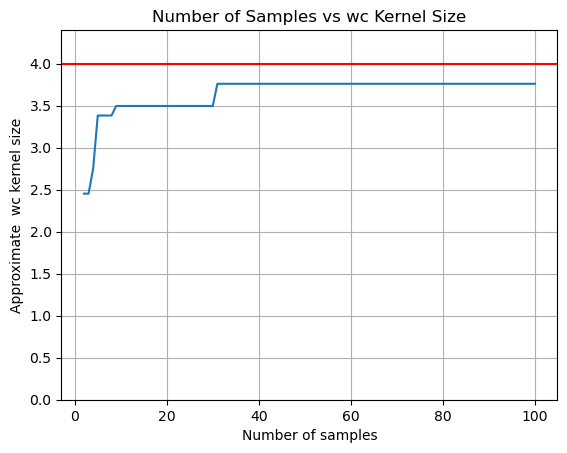

Total Max Kernel Size: 3.7611457367131327
Analytical Kernel Size: 4
Relative Error: -0.05971356582171683


In [13]:
# check if P_{N(A)}(M_1) of first toy example set is symmetric

# Toy example 1

R = 2  # Radius of the ball
num_points = 500  # Number of points in the set M_1
A = np.diag([1, 1, 0])  # Transformation matrix
#analytical kersize
ker_size = 2*R
av_ker_size = 2.309 
p=2

# Generate points in B_R(0)
target_data = random_points_in_ball(R, num_points)
input_data =  apply_forwardmodel(A, target_data)

# Set the range of k values
max_k = 100

wc_kersizes = []
for k in range(1,max_k,1):
    input_data_k = input_data[0:k,:]
    wc_kersize_k = wc_kernelsize(A, input_data_k, target_data, p, epsilon=1e-1)
    print(wc_kersize_k)
    wc_kersizes.append(wc_kersize_k)

wc_kersizef = wc_kersizes[-1]

plot_wckersize_conv(wc_kersizef, wc_kersizes, ker_size, max_k)


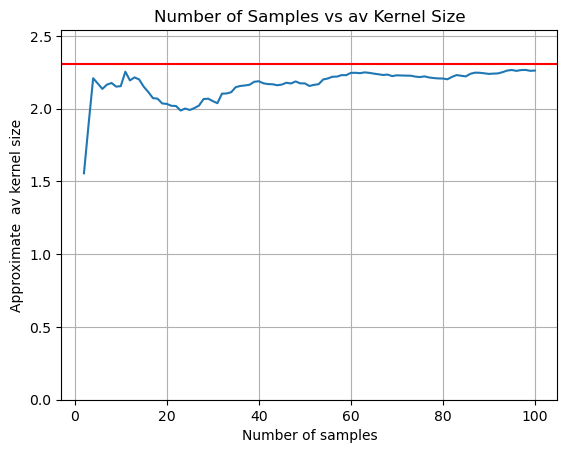

Total Max Kernel Size: 2.261954436469226
Analytical Kernel Size: 2.309
Relative Error: -0.020374865106441865


In [14]:
# check if P_{N(A)}(M_1) of first toy example set is symmetric

# Toy example 1

R = 2  # Radius of the ball
num_points = 500  # Number of points in the set M_1
A = np.diag([1, 1, 0])  # Transformation matrix
#analytical kersize
ker_size = 2*R
av_ker_size = 2.309 
p=2

# Generate points in B_R(0)
target_data = random_points_in_ball(R, num_points)
input_data =  apply_forwardmodel(A, target_data)

# Set the range of k values
max_k = 100

av_kersizes = []
for k in range(1,max_k,1):
    input_data_k = input_data[0:k,:]
    av_kersize_k = av_kernelsize(A, input_data_k, target_data, p, epsilon=1e-1)
    av_kersizes.append(av_kersize_k)

av_kersizef = av_kersizes[-1]

plot_avkersize_conv(av_kersizef, av_kersizes, av_ker_size, max_k)

In [15]:
np.linalg.norm([1,2,3], ord = 2)

3.7416573867739413